In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm_notebook, tnrange
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate,add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array,load_img,array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import statistics

2023-02-23 00:04:29.037205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def count_img(root, total, folders, total_count, text):
    for filename in tqdm(os.listdir(root)):
        if filename != ".DS_Store":
            folders.append(filename)
            ids = next(os.walk(root+'/'+filename))[2]# list of names all images in the given path
            total_count.append(len(ids))
            total +=len(ids)
    print(text)
    print("Number of images and masks = ", total)
    print("The folders containing images and masks are :", folders)
    print("Image tally accordingly :", total_count)
    return total, folders, total_count

In [3]:
def mac_equalizer(total_count):
    for i in range(len(total_count)):
        if total_count[i] % 2 != 0 :
            total_count[i] -= 1
    print("New count is :", total_count)
    print("New total = ", sum(total_count))
    return total_count,sum(total_count)

In [4]:
def upload(root, folders, X, y, text):
    count_img = 0
    count_mask = 0
    
    print(text)
    
    for file in folders : 
        image_dir_path = root+ "/" +file
        mask_dir_path =  root+ "/" +file
        
        for img_path in tqdm(sorted(glob.glob(os.path.join(image_dir_path, "*_img.png")))):
            img = load_img(img_path, color_mode = "grayscale")
            img = img_to_array(img)
            img = resize(img, (128, 128, 1), mode = 'constant', preserve_range = True)
            img = img/255.0
            X[count_img]=img 
            count_img+=1
        print("Image upload count = ", count_img)
        
        
        for mask_path in tqdm(sorted(glob.glob(os.path.join(mask_dir_path, "*_mask.png")))):
            mask = load_img(mask_path, color_mode = "grayscale")
            mask = img_to_array(mask)
            mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
            mask = mask/255.0
            y[count_mask]=mask
            count_mask+=1
        print("Mask upload count = ", count_mask)
    return X,y

In [5]:
def pre_visualize(X, y, text, ix = None) :
    
    print(text)
    for i in range(5) : 
        if ix == None :
            ix = random.randint(0, len(X)-1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
        ax1.imshow(X[ix], cmap = 'gray', interpolation = 'bilinear')
        ax1.set_title('Image')
        
        ax2.imshow(y[ix], cmap = 'gray', interpolation = 'bilinear')
        ax2.set_title('Mask')
        ix = None

In [6]:
train_text = "\t\t\t\t\t\tTraining "
valid_text = "\t\t\t\t\t\tValidation "
test_text = "\t\t\t\t\t\t\tTesting "
train_total = 0
test_total = 0
train_total_count = []
test_total_count = []
train_folders = []
test_folders = []
train_root = "/Users/anveshsk/Dropbox/capstone_data/train_local"
test_root = "/Users/anveshsk/Dropbox/capstone_data/test"

train_total, train_folders, train_total_count = count_img(train_root, train_total, train_folders, train_total_count, "Training")
test_total, test_folders, test_total_count = count_img(test_root, test_total, test_folders, test_total_count, "Testing")


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4494.30it/s]


Training
Number of images and masks =  457
The folders containing images and masks are : ['SS_EA031', 'SS_045', 'EA036_SS', 'SS', 'SS_EA_050', 'SS_3', 'SS_EA026']
Image tally accordingly : [157, 56, 45, 63, 51, 42, 43]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 2154.42it/s]

Testing
Number of images and masks =  54
The folders containing images and masks are : ['SS_EA001', 'SS_EA041', 'SS_EA025', 'SS_EA034', 'SS_EA002']
Image tally accordingly : [10, 10, 10, 13, 11]


In [7]:
train_total_count, train_total = mac_equalizer(train_total_count)
test_total_count, test_total = mac_equalizer(test_total_count)

New count is : [156, 56, 44, 62, 50, 42, 42]
New total =  452
New count is : [10, 10, 10, 12, 10]
New total =  52


In [8]:
im_width = 128
im_height = 128

X = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)

X_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)
y_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)

In [9]:
X, y = upload(train_root, train_folders, X, y, train_text)

						Training 


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 69.87it/s]


Image upload count =  78


100%|███████████████████████████████████████████| 78/78 [00:00<00:00, 86.77it/s]


Mask upload count =  78


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 72.08it/s]


Image upload count =  106


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 92.76it/s]


Mask upload count =  106


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 75.21it/s]


Image upload count =  128


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 91.25it/s]


Mask upload count =  128


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 75.35it/s]


Image upload count =  159


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 92.06it/s]


Mask upload count =  159


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 76.31it/s]


Image upload count =  184


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 90.83it/s]


Mask upload count =  184


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 73.22it/s]


Image upload count =  205


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 90.74it/s]


Mask upload count =  205


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 75.81it/s]


Image upload count =  226


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 91.66it/s]

Mask upload count =  226


In [10]:
X_test, y_test = upload(test_root, test_folders, X_test, y_test, test_text)

							Testing 


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 73.84it/s]


Image upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 87.64it/s]


Mask upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 78.79it/s]


Image upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 88.69it/s]


Mask upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 76.17it/s]


Image upload count =  15


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 89.97it/s]


Mask upload count =  15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 69.96it/s]


Image upload count =  21


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 88.99it/s]


Mask upload count =  21


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 73.93it/s]


Image upload count =  26


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 89.57it/s]

Mask upload count =  26


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [12]:
len(X_train)

180

In [13]:
len(X_valid)

46

						Training 


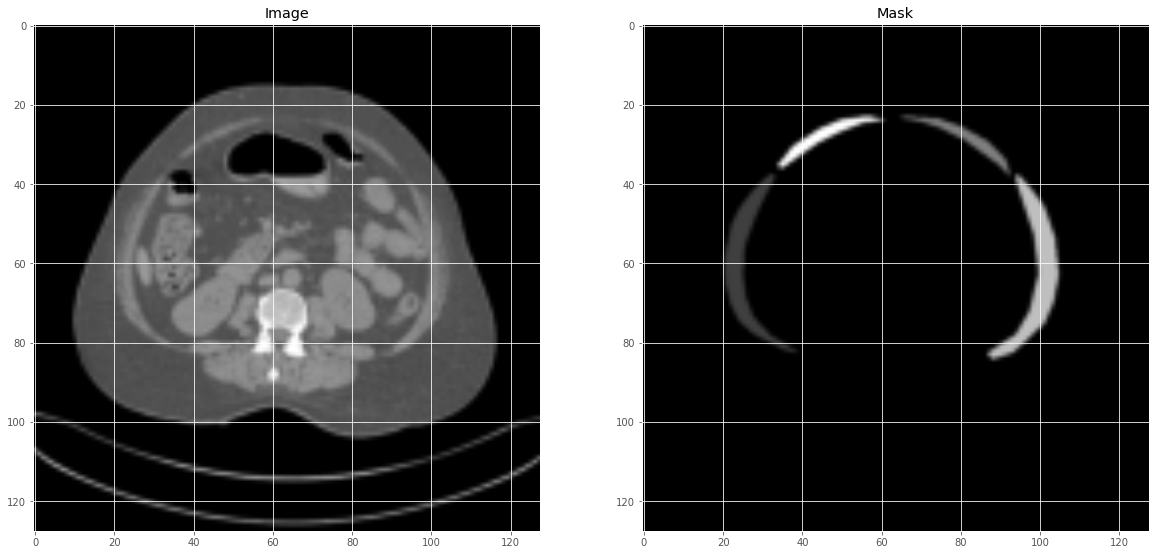

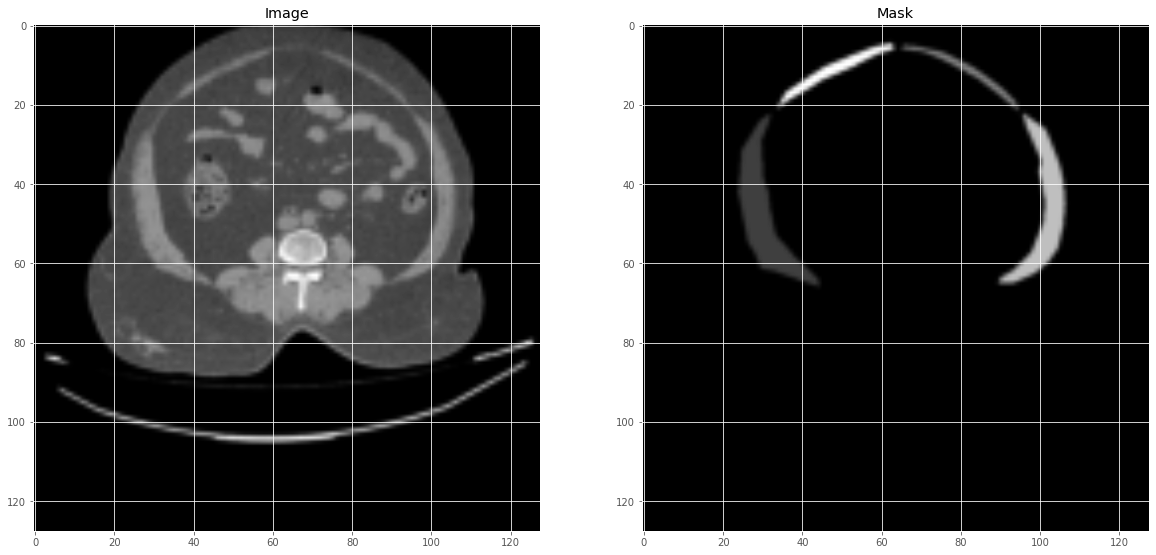

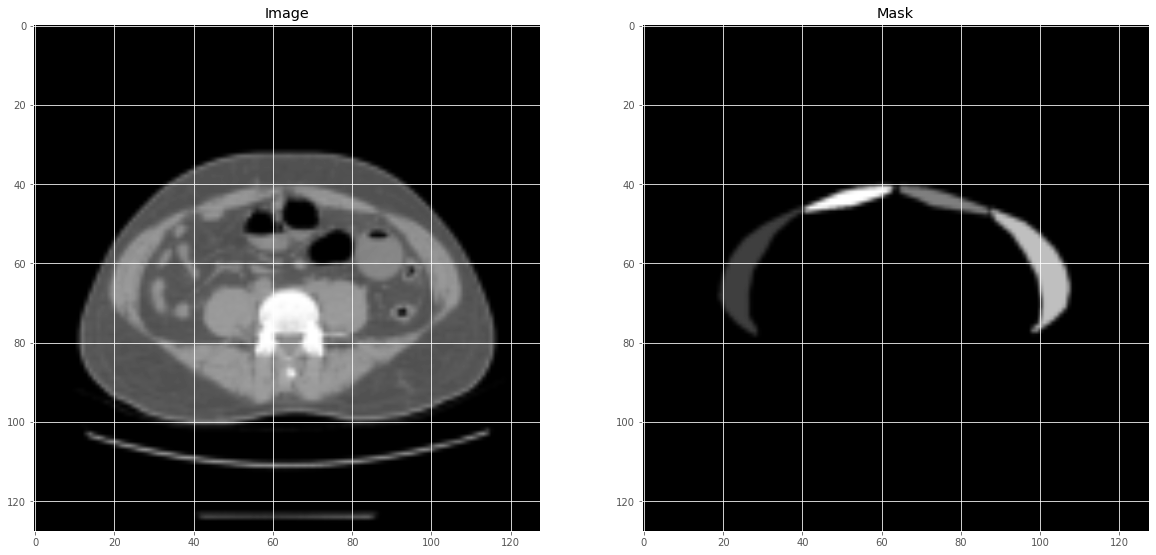

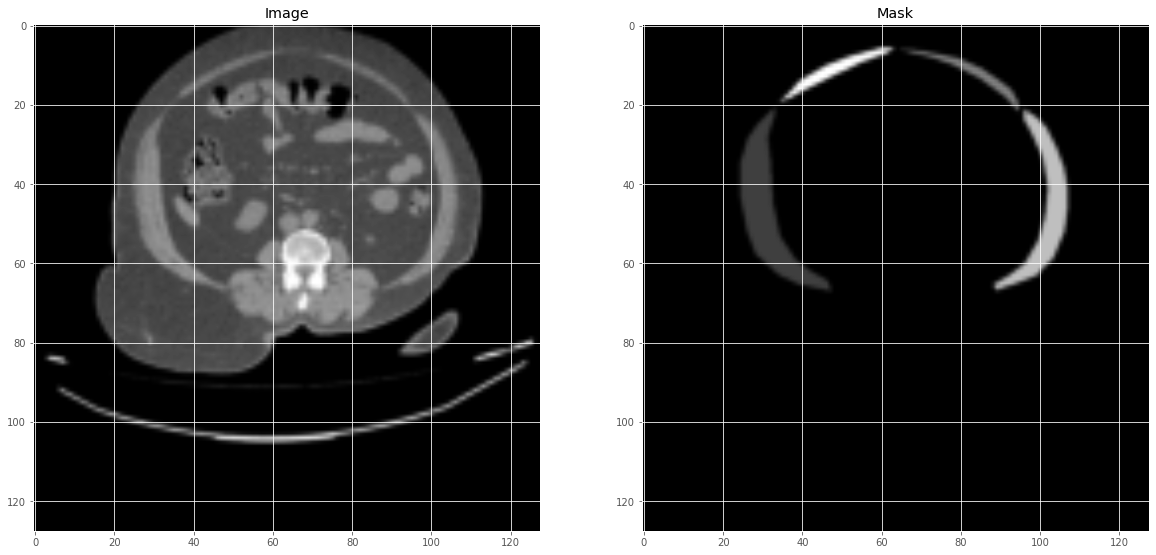

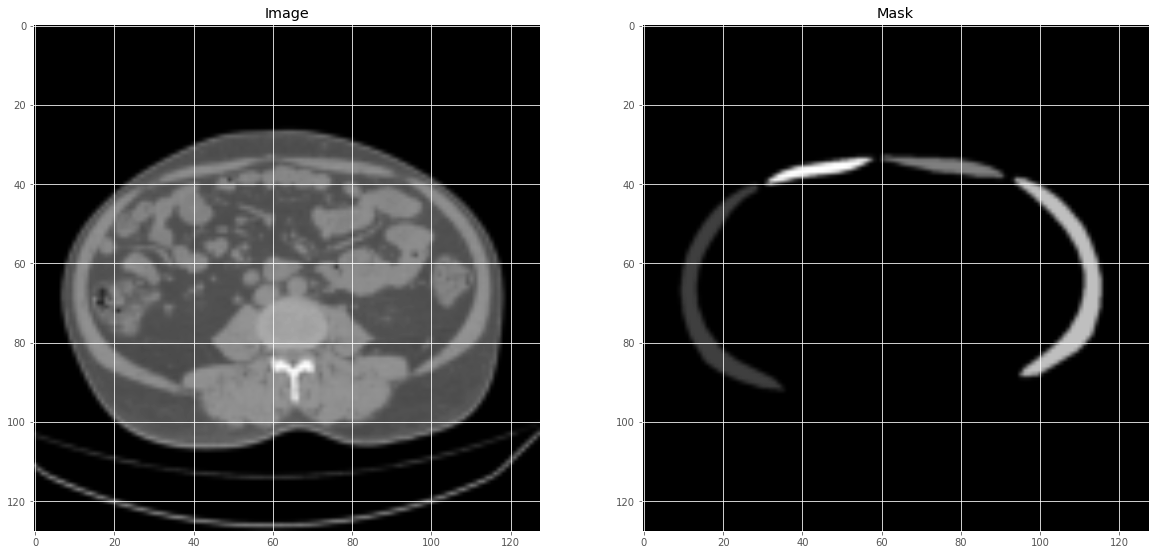

In [14]:
pre_visualize(X_train, y_train, train_text)

						Validation 


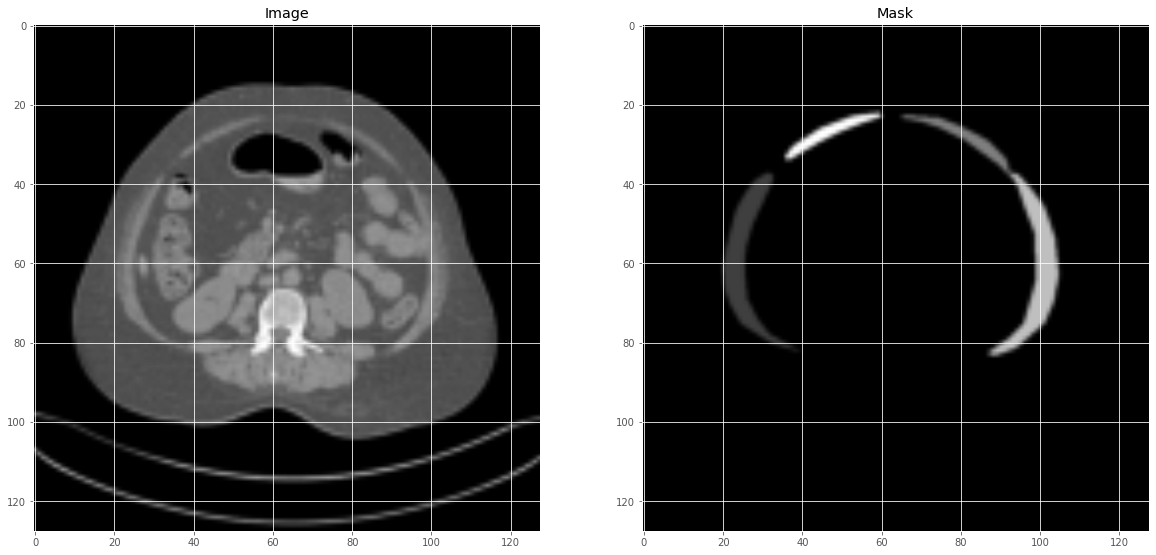

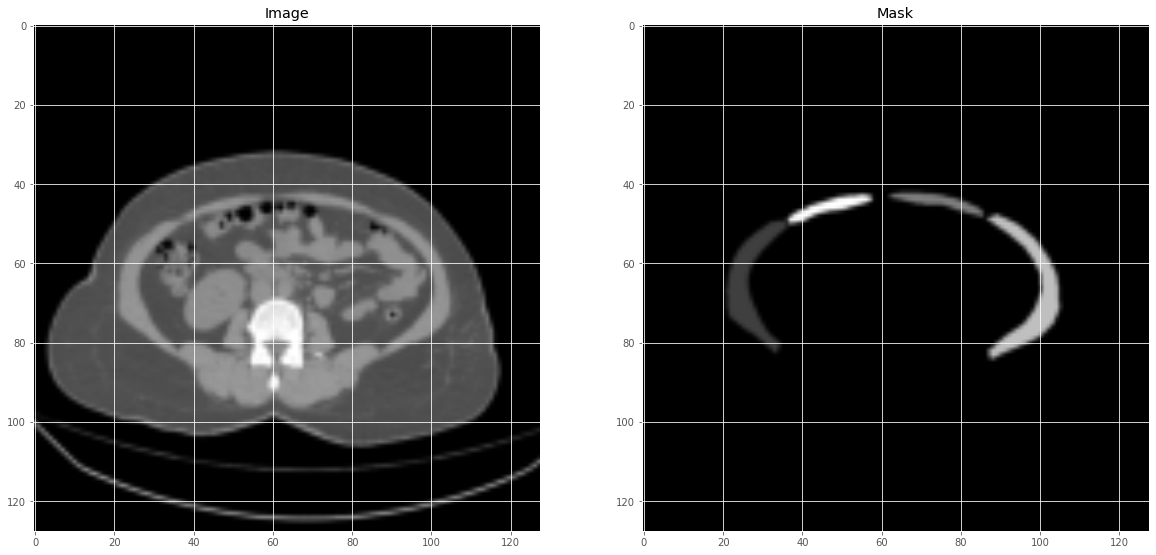

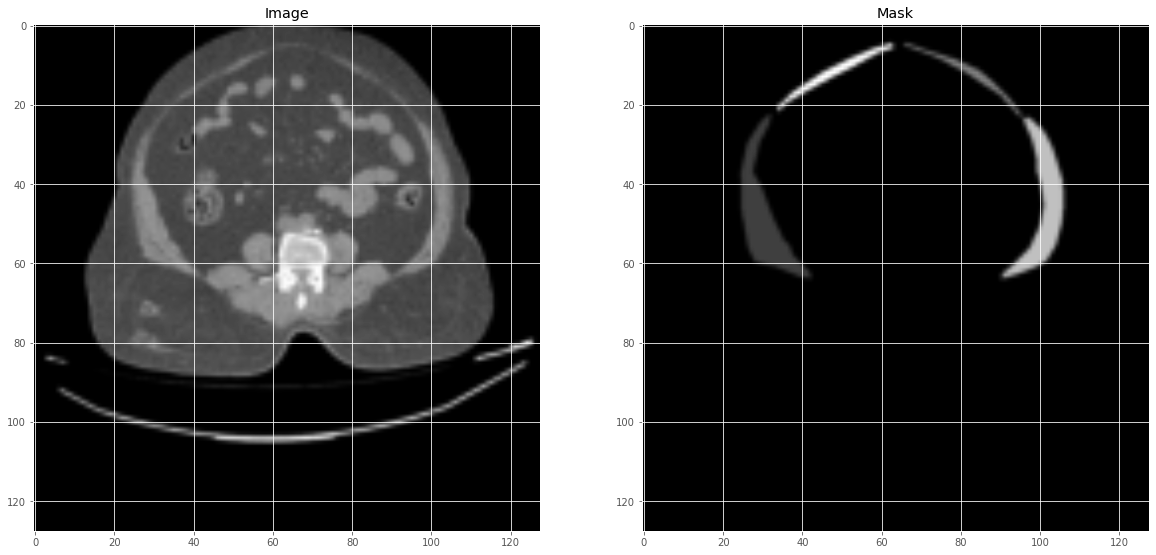

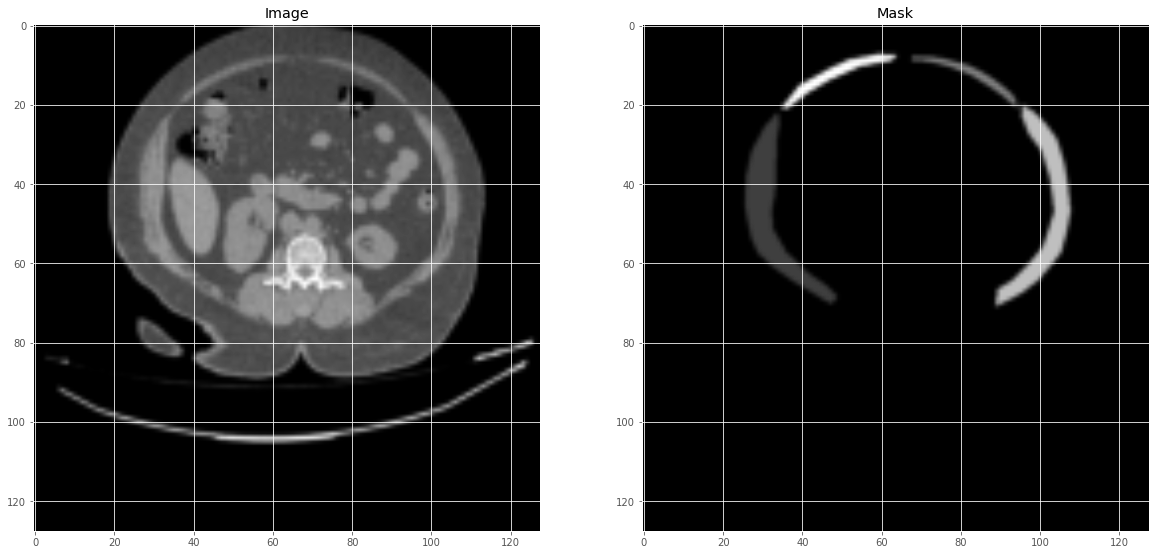

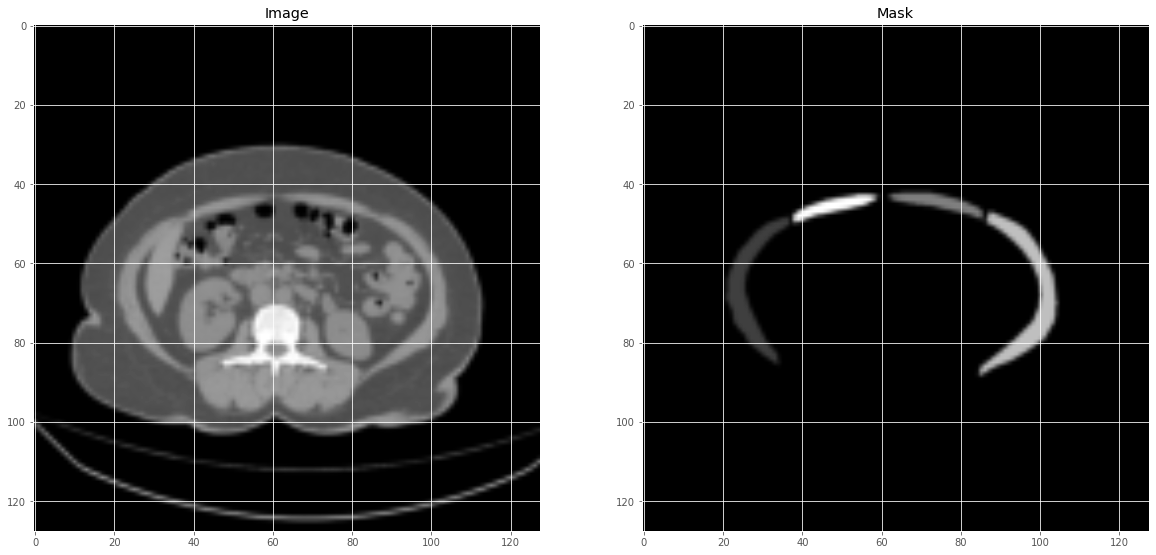

In [15]:
pre_visualize(X_valid, y_valid, valid_text)

							Testing 


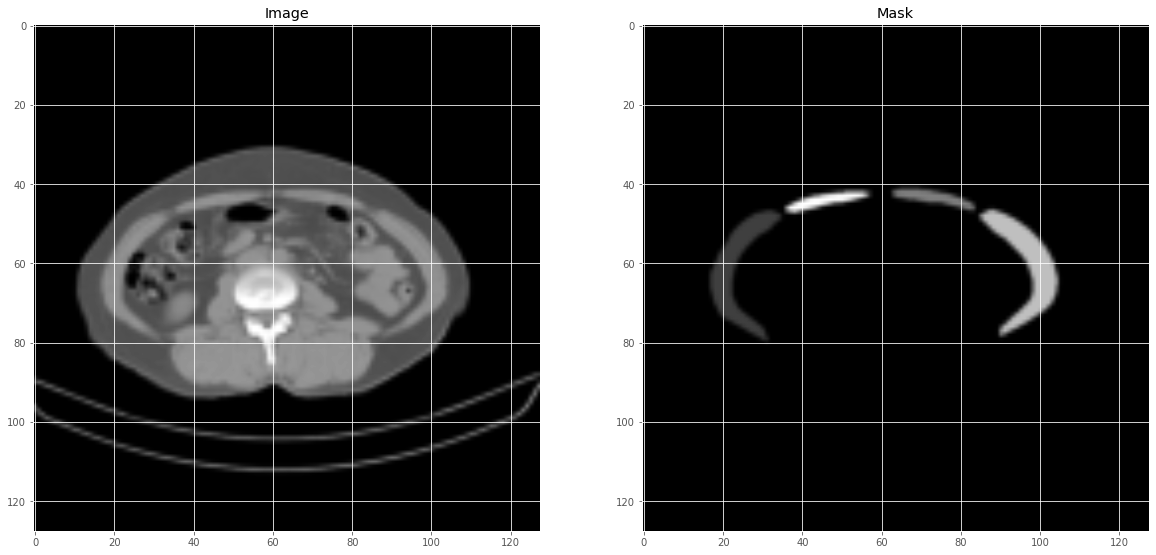

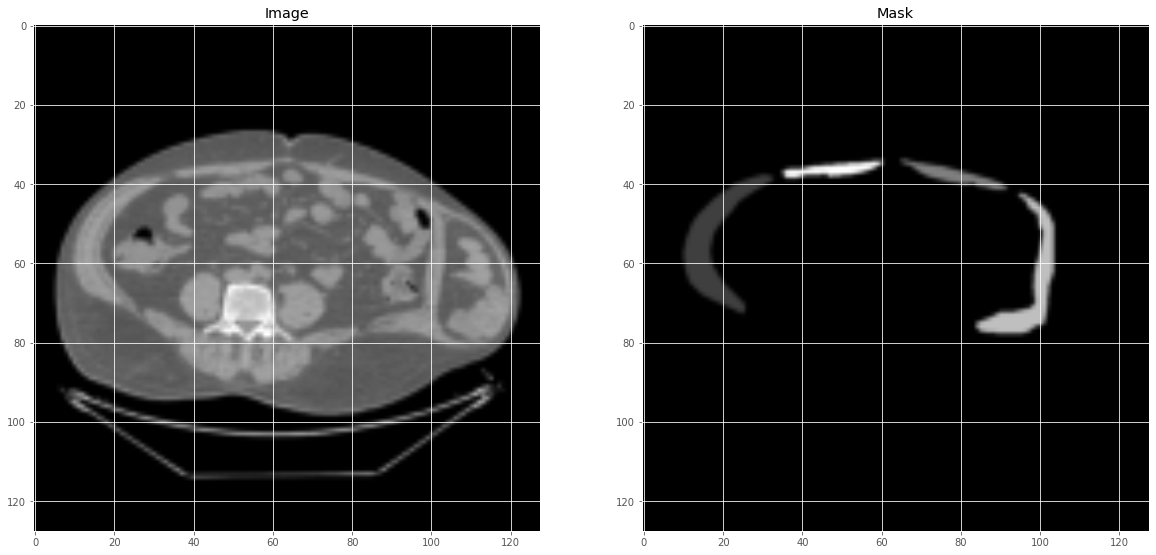

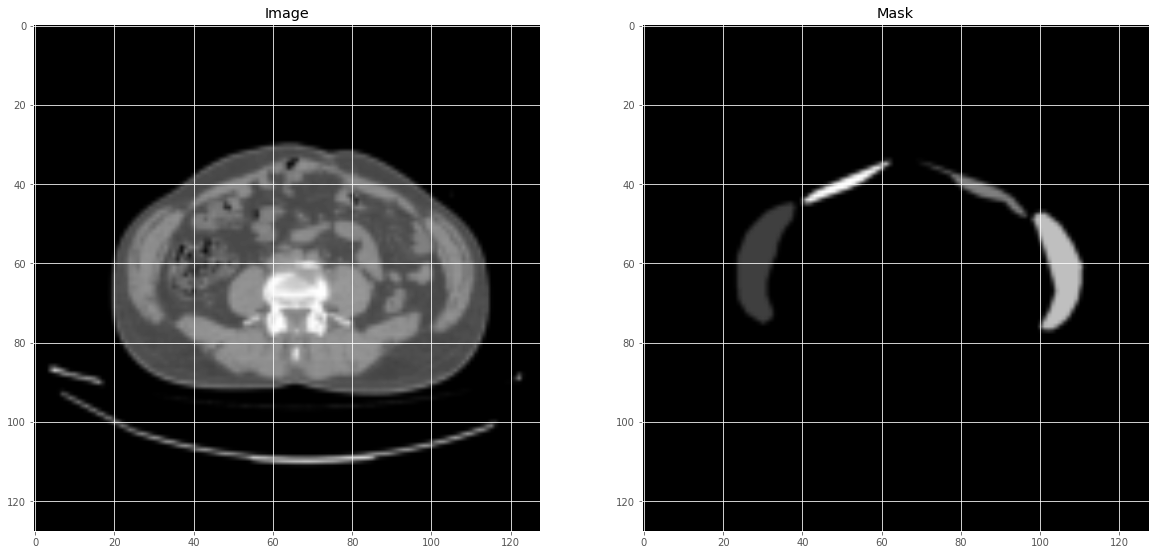

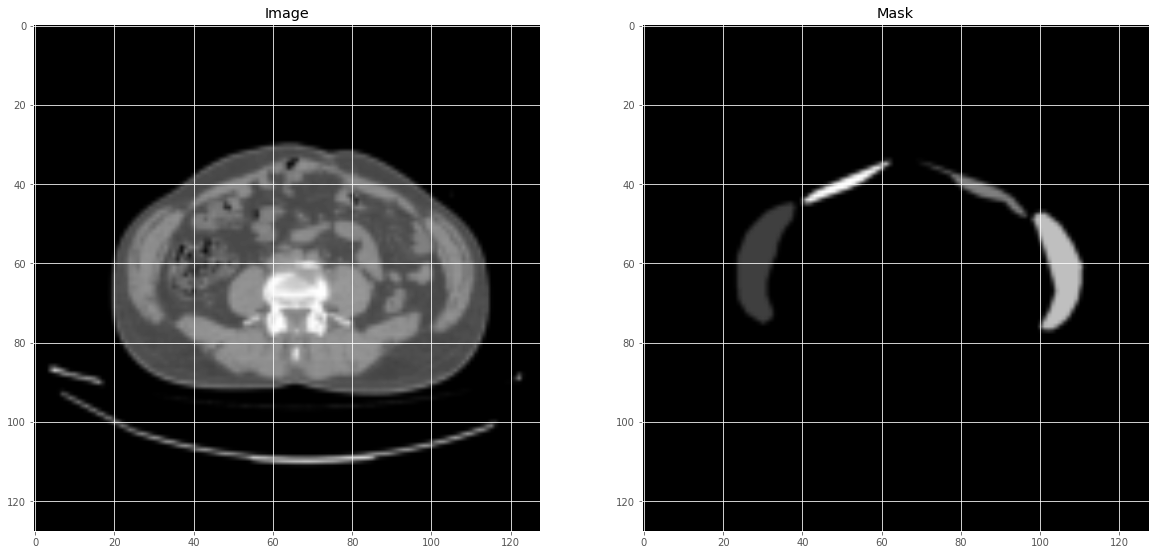

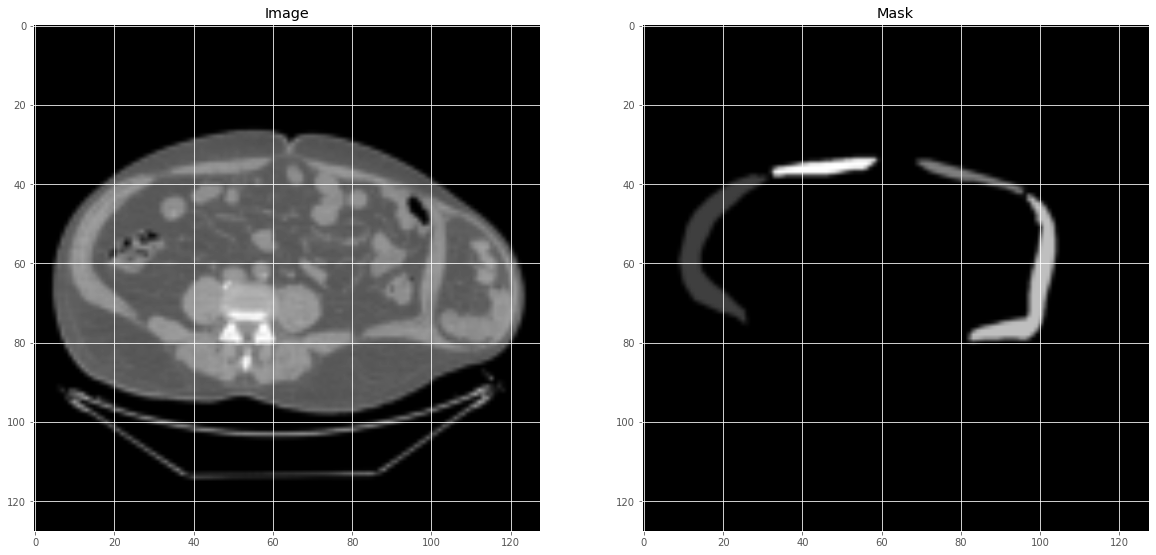

In [16]:
pre_visualize(X_test, y_test, test_text)

In [19]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [20]:
#UNet Architecture 
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [21]:
from keras import backend as K


def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (2. * intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + K.epsilon())
    return 1. - val

In [22]:
from keras import backend as K
def iou_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection + K.epsilon())
    return 1. - val

In [23]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy"])

2023-02-23 00:05:13.037753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 256)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 256)    590080      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

                                )                                 'activation_1[0][0]']           
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128, 128, 16  64         ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
          

In [25]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [26]:
results = model.fit(X_train, y_train, batch_size=32, epochs=80, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/80
6/6 [==============================] - ETA: 0s - loss: 0.9300 - accuracy: 0.2057
Epoch 1: val_loss improved from inf to 0.92487, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 16s 2s/step - loss: 0.9300 - accuracy: 0.2057 - val_loss: 0.9249 - val_accuracy: 0.5054 - lr: 0.0010
Epoch 2/80
6/6 [==============================] - ETA: 0s - loss: 0.9018 - accuracy: 0.4947
Epoch 2: val_loss did not improve from 0.92487
6/6 [==============================] - 11s 2s/step - loss: 0.9018 - accuracy: 0.4947 - val_loss: 0.9337 - val_accuracy: 0.6781 - lr: 0.0010
Epoch 3/80
6/6 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.6595
Epoch 3: val_loss did not improve from 0.92487
6/6 [==============================] - 10s 2s/step - loss: 0.8682 - accuracy: 0.6595 - val_loss: 0.9310 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 4/80
6/6 [==============================] - ETA: 0s - loss: 0.8283 - accuracy: 0.8422
Epo

Epoch 25/80
6/6 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.9203
Epoch 25: val_loss improved from 0.56484 to 0.52855, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 11s 2s/step - loss: 0.3417 - accuracy: 0.9203 - val_loss: 0.5286 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 26/80
6/6 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.9203
Epoch 26: val_loss improved from 0.52855 to 0.51100, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 11s 2s/step - loss: 0.3197 - accuracy: 0.9203 - val_loss: 0.5110 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 27/80
6/6 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.9203
Epoch 27: val_loss improved from 0.51100 to 0.48881, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 11s 2s/step - loss: 0.3000 - accuracy: 0.9

Epoch 49/80
6/6 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9203
Epoch 49: val_loss improved from 0.12790 to 0.12084, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 11s 2s/step - loss: 0.0859 - accuracy: 0.9203 - val_loss: 0.1208 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 50/80
6/6 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9203
Epoch 50: val_loss improved from 0.12084 to 0.11381, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 11s 2s/step - loss: 0.0816 - accuracy: 0.9203 - val_loss: 0.1138 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 51/80
6/6 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.9203
Epoch 51: val_loss improved from 0.11381 to 0.11023, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 11s 2s/step - loss: 0.0794 - accuracy: 0.9

6/6 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9203
Epoch 74: val_loss improved from 0.05354 to 0.05152, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 10s 2s/step - loss: 0.0445 - accuracy: 0.9203 - val_loss: 0.0515 - val_accuracy: 0.9223 - lr: 1.0000e-04
Epoch 75/80
6/6 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9203
Epoch 75: val_loss improved from 0.05152 to 0.05106, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 10s 2s/step - loss: 0.0438 - accuracy: 0.9203 - val_loss: 0.0511 - val_accuracy: 0.9223 - lr: 1.0000e-04
Epoch 76/80
6/6 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9203
Epoch 76: val_loss improved from 0.05106 to 0.04971, saving model to model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5
6/6 [==============================] - 10s 2s/step - loss: 0.0434 - accuracy: 0.9203 

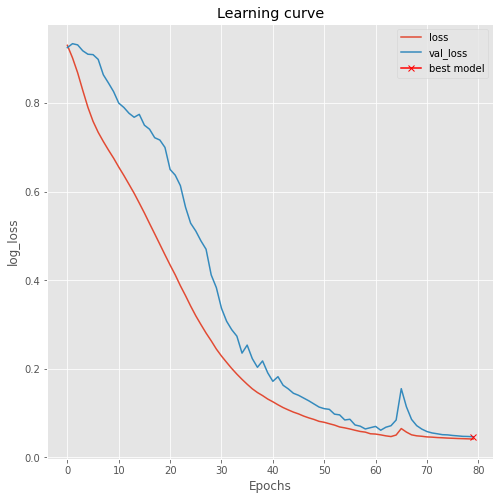

In [27]:
#plotting Learning curve ( log_loss vs epochs)
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [28]:
# load the best model
model.load_weights('model_local_stdUNet_DLE_final_run1_E60-tgs-salt.h5')

In [29]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_train, y_train, verbose=1)
model.evaluate(X_valid, y_valid, verbose=1)
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 292ms/step - loss: 0.1739 - accuracy: 0.9240


[0.1739291548728943, 0.9239572286605835]

In [30]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 285ms/step


In [31]:
#Function for viewing plots and predictions
def plot_sample(X, y, preds,text, ix=None):
    """Function to plot the results"""
    print(text) 
    
    for i in range(5) : 
        if ix is None:
            ix = random.randint(0, len(X)-1)
            
        fig, ax = plt.subplots(1, 3, figsize=(25, 15))
        ax[0].imshow(X[ix], cmap='gray')
        ax[0].set_title('Input')

        ax[1].imshow(y[ix].squeeze(),cmap='gray')
        ax[1].set_title('Mask')


        ax[2].imshow(preds[ix].squeeze(),cmap='gray')
        ax[2].set_title('Mask Predicted')
        
        d_loss = dice_loss(y[ix],preds[ix]).numpy()
        d_loss = round(d_loss*100, 3)
        
        i_loss = iou_loss(y[ix],preds[ix]).numpy()
        i_loss = round(i_loss*100, 3)
        
        text_1 = "Dice loss of image " + str(ix) +  " = " + str(d_loss) + " %"
        text_2 = "IoU loss of image " + str(ix) +  " = " + str(i_loss) + " %"
        plt.figtext(0.4, 0.2, text_1, fontsize=18)
        plt.figtext(0.4, 0.18, text_2, fontsize=18)
        
        ix = None

						Training 


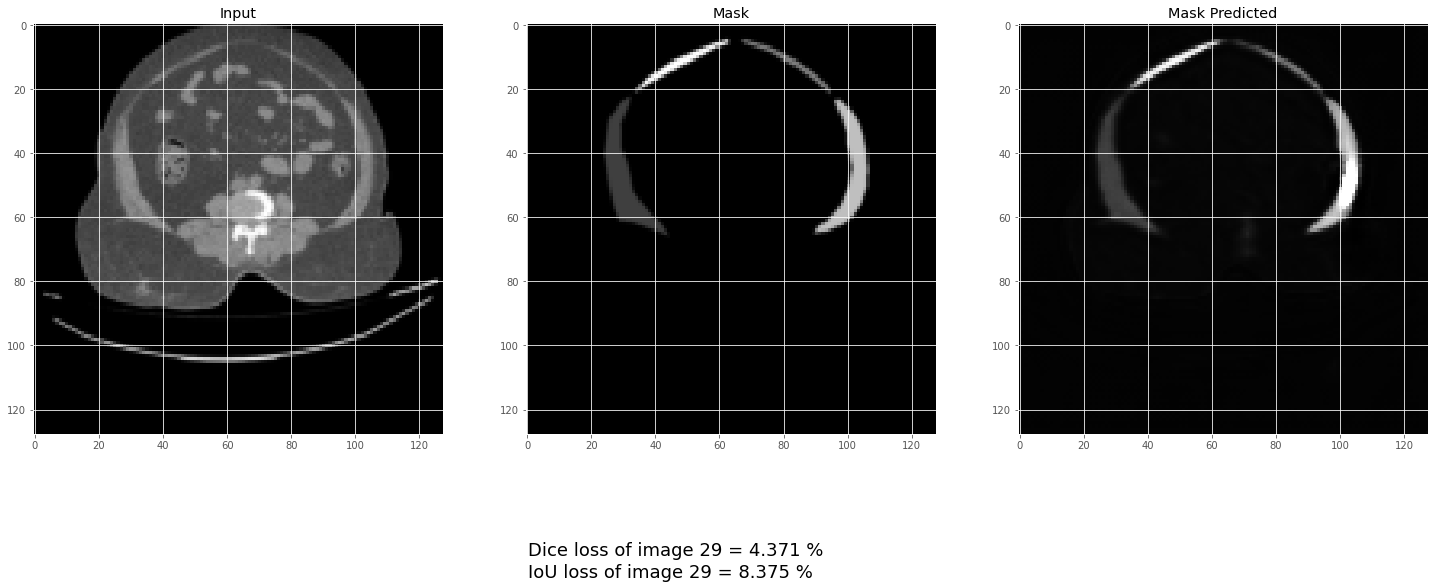

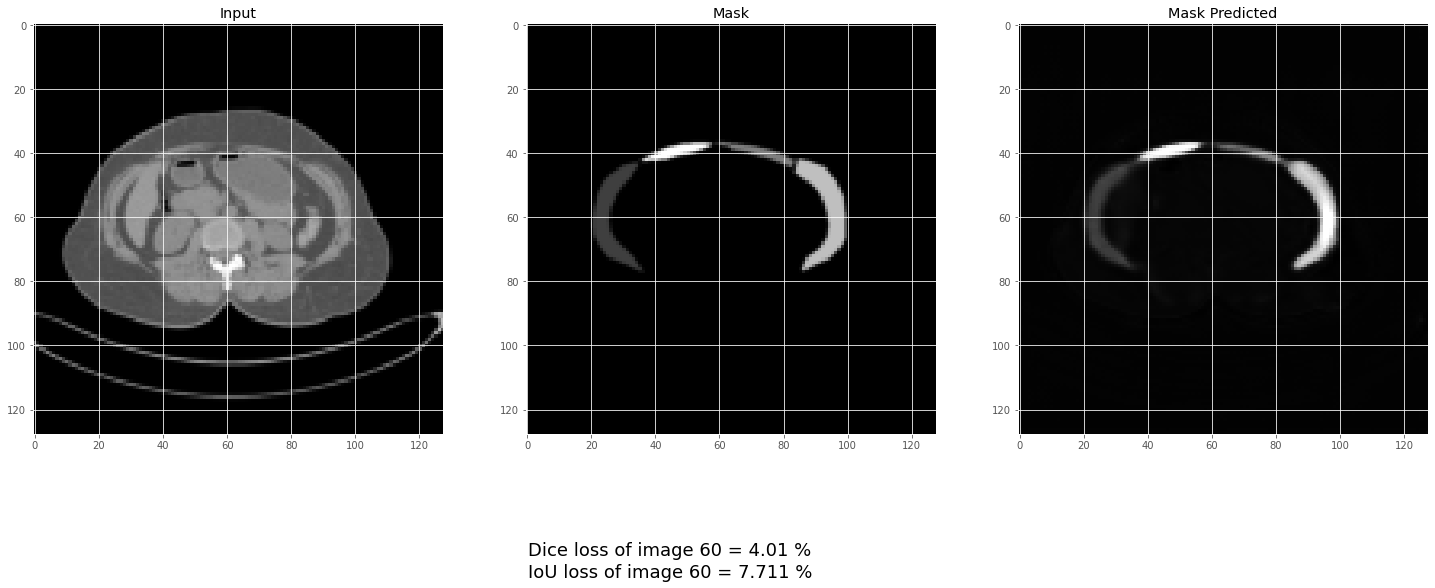

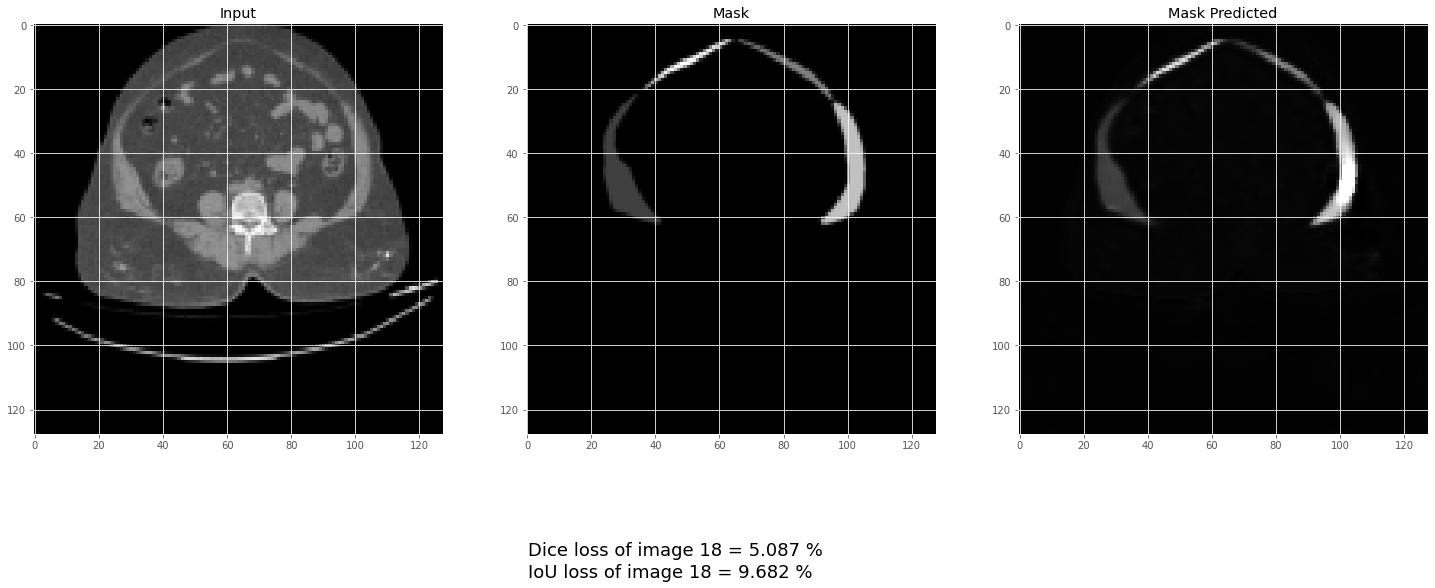

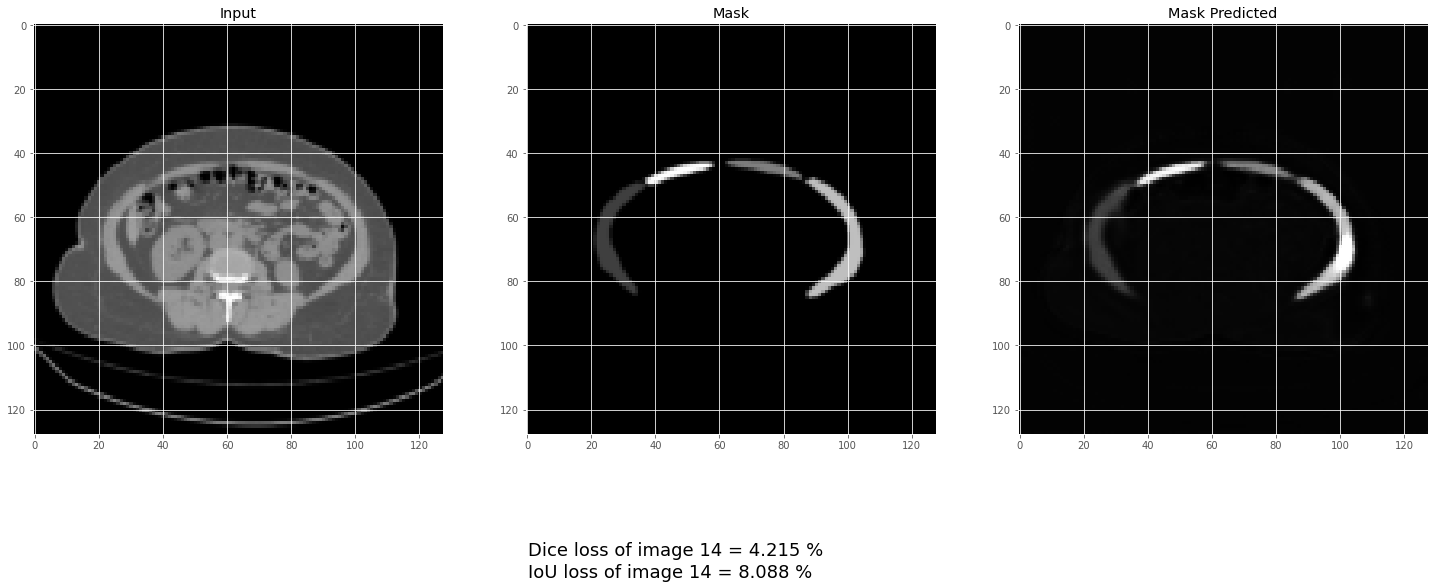

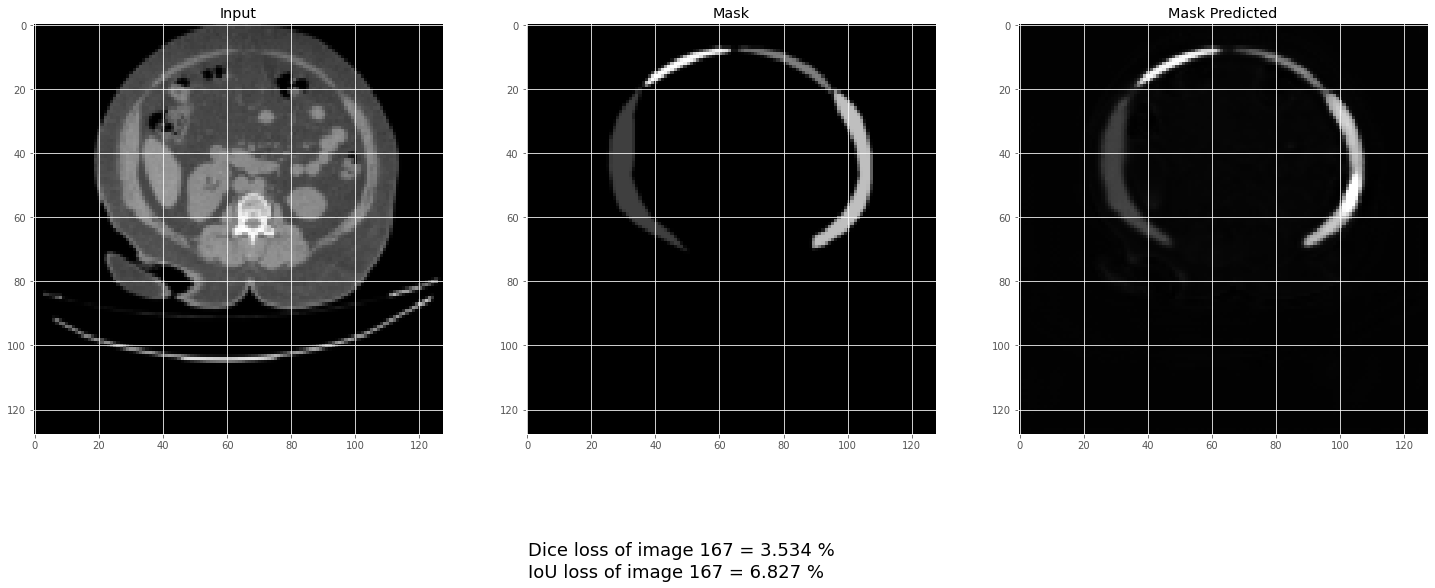

In [32]:
plot_sample(X_train, y_train, preds_train, train_text)

						Validation 


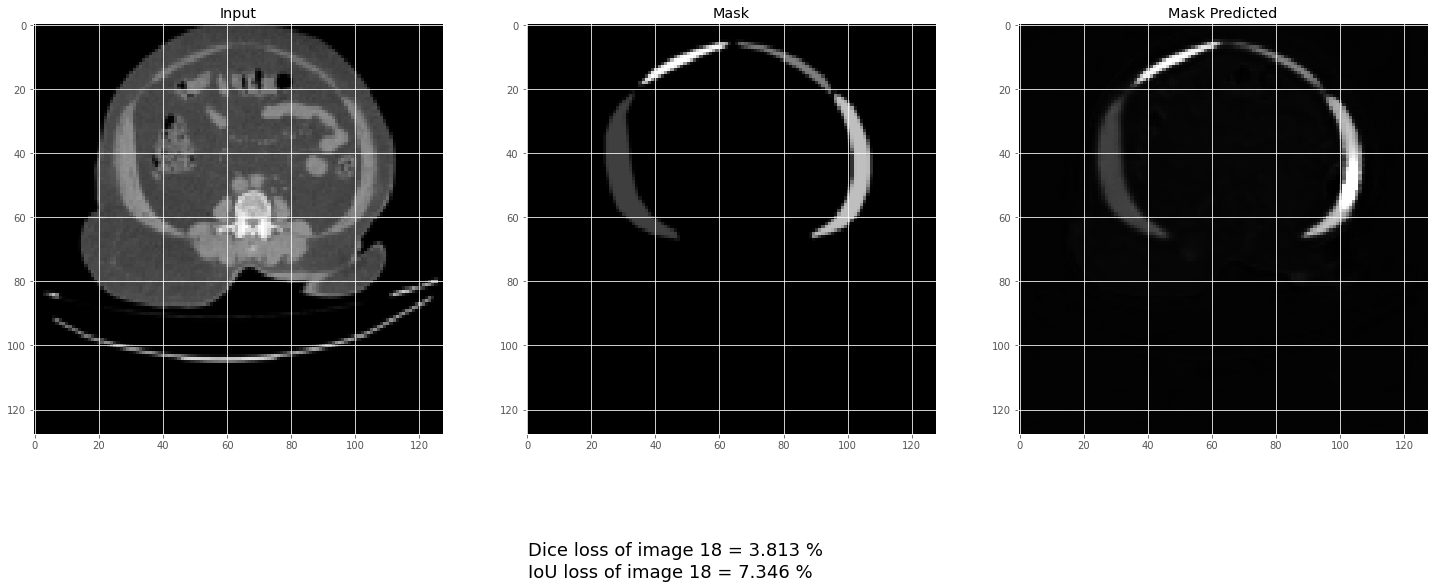

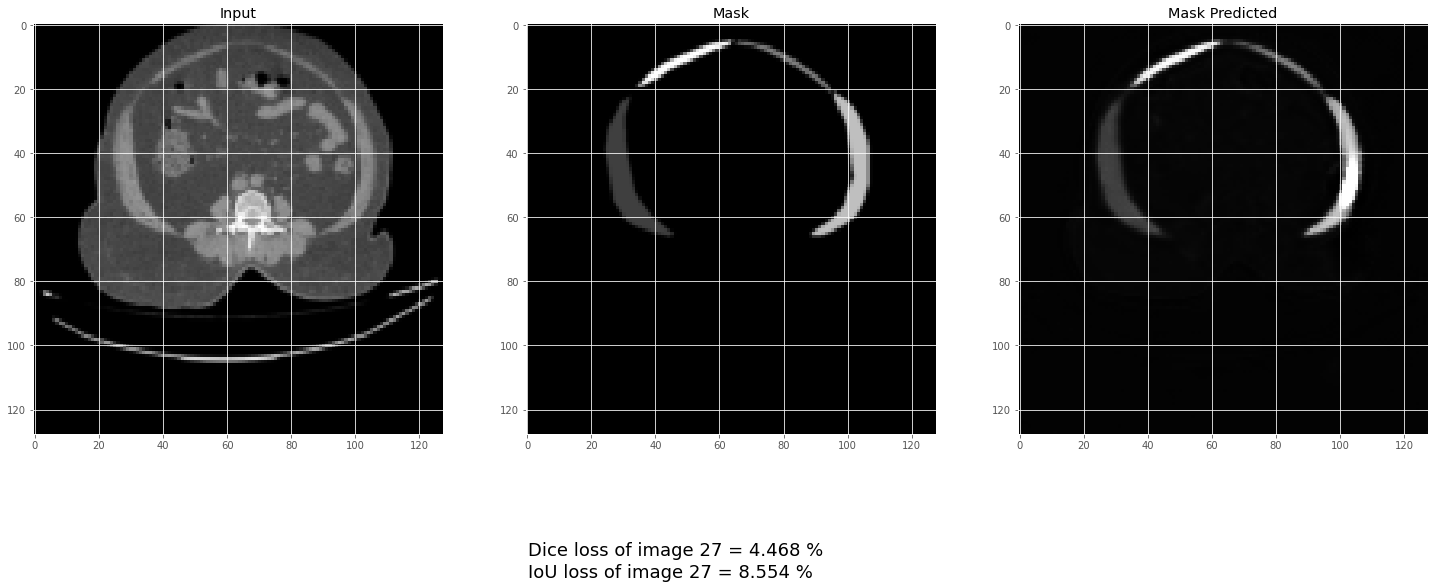

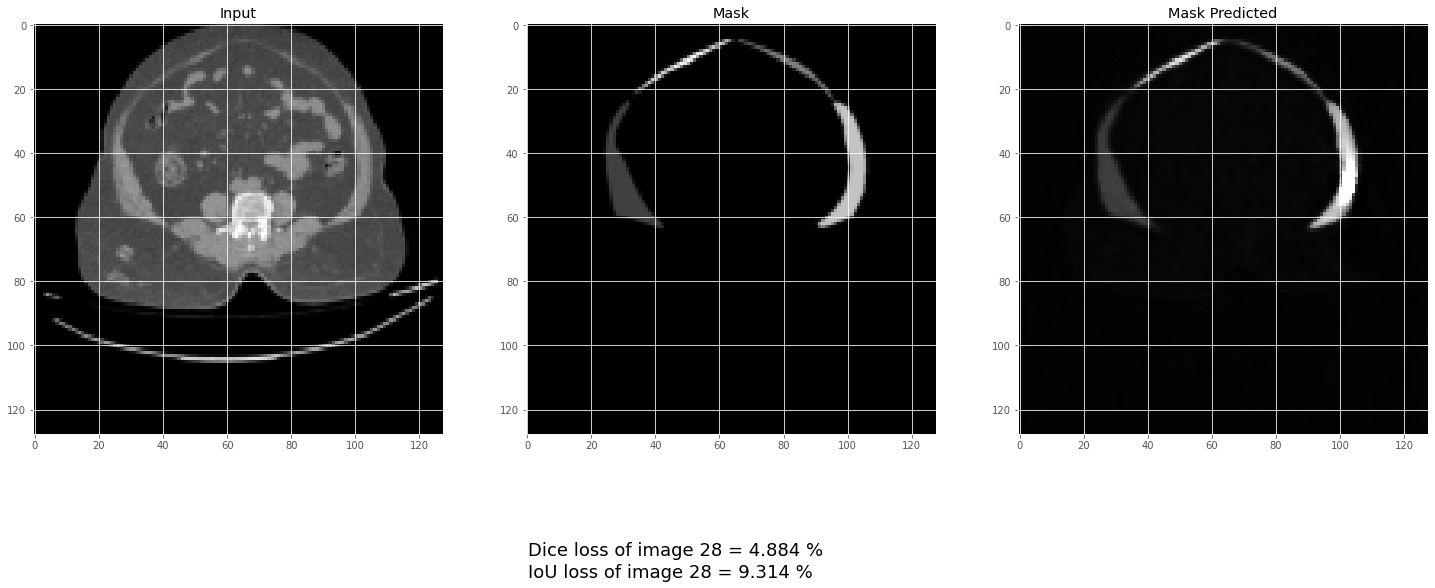

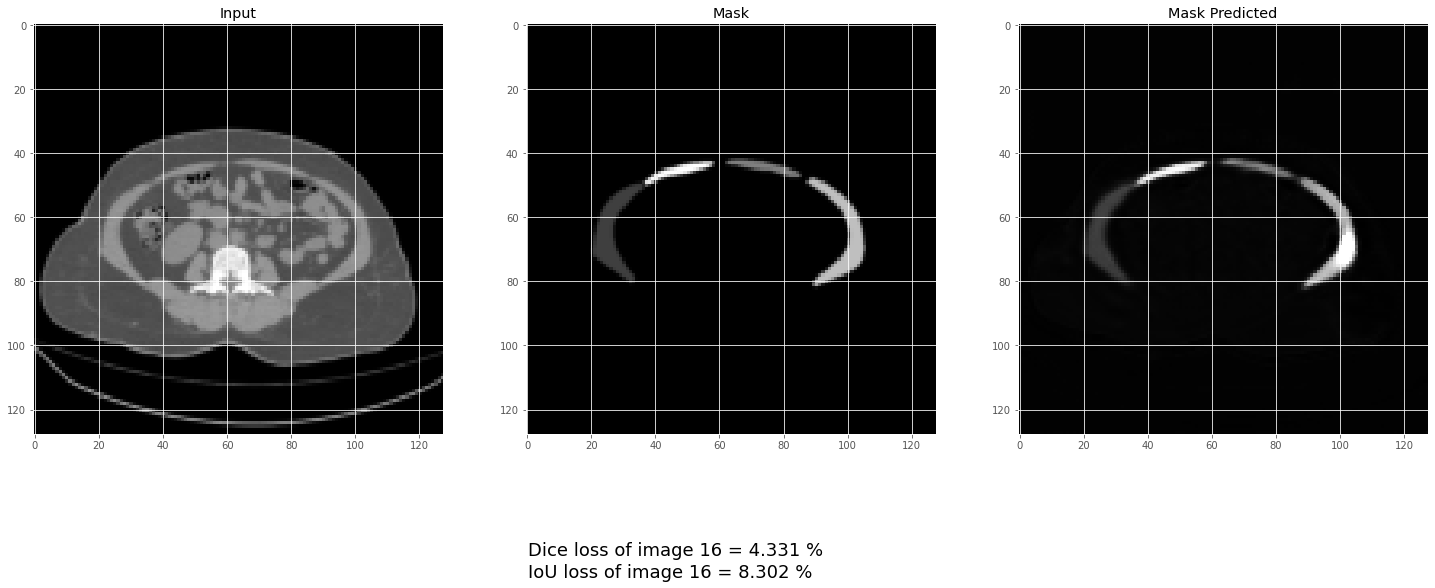

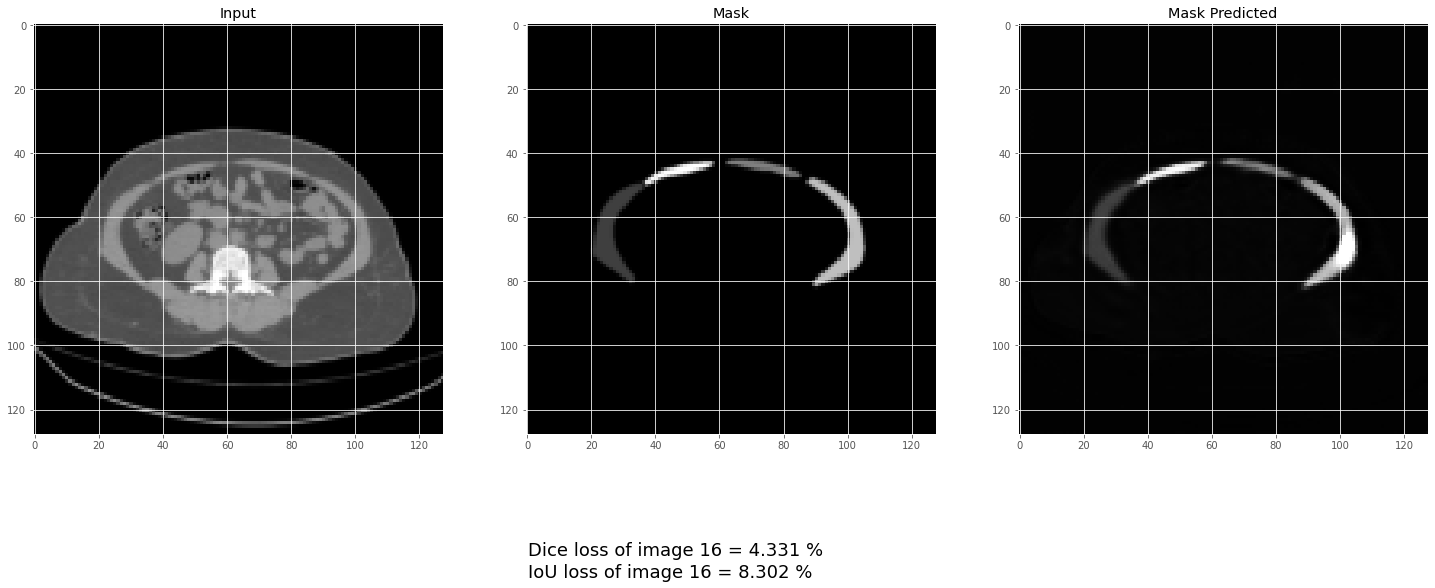

In [33]:
plot_sample(X_valid, y_valid, preds_val, valid_text)

							Testing 


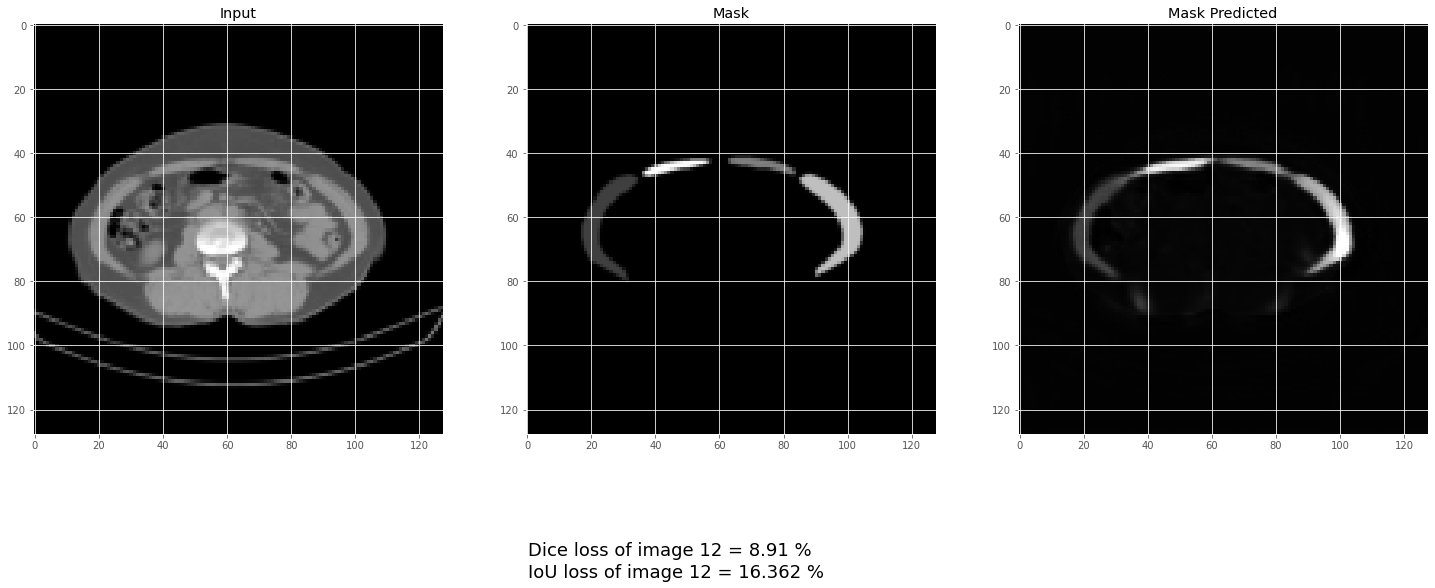

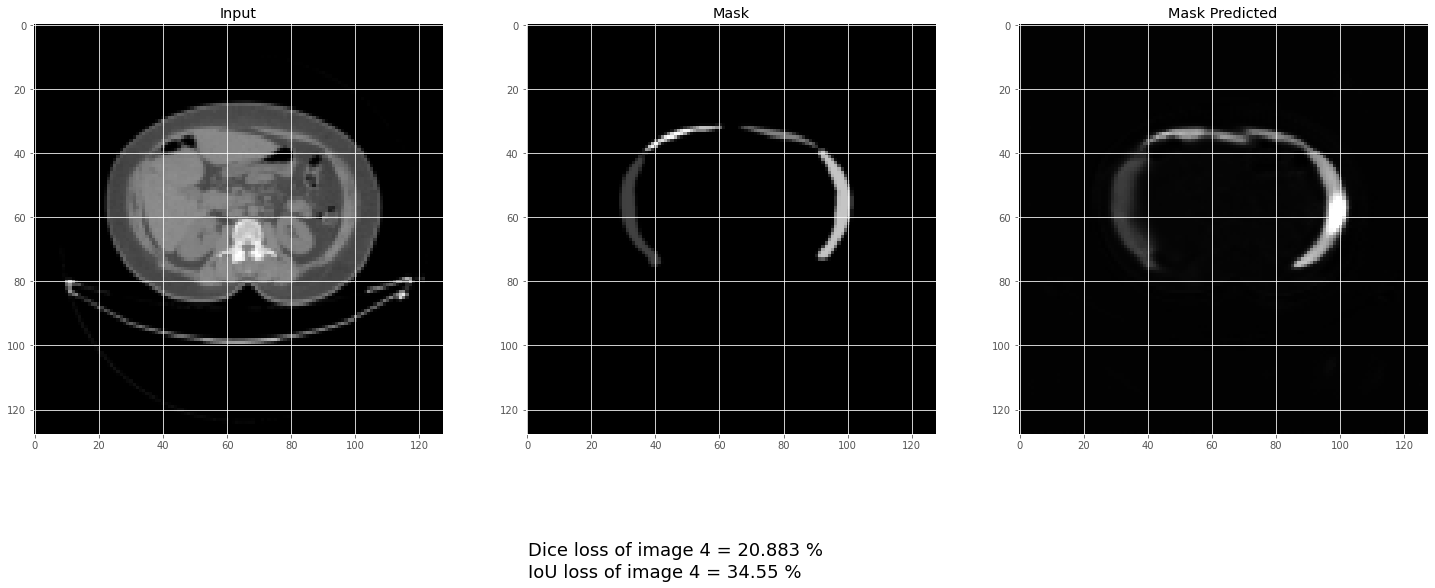

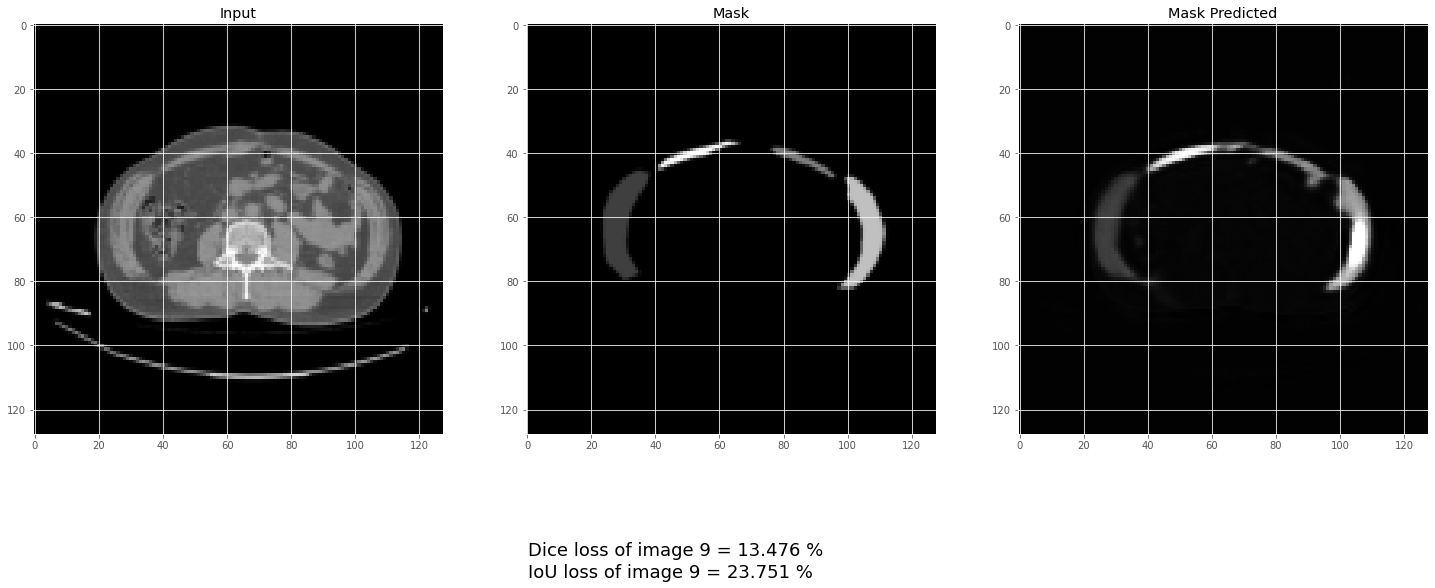

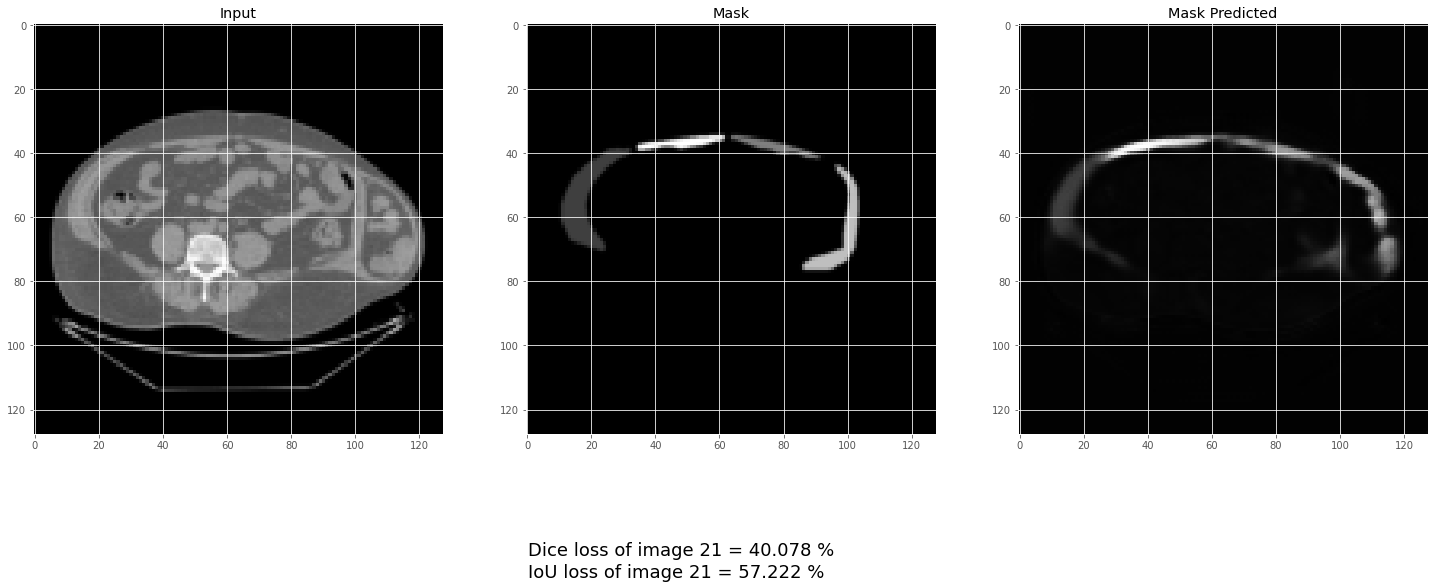

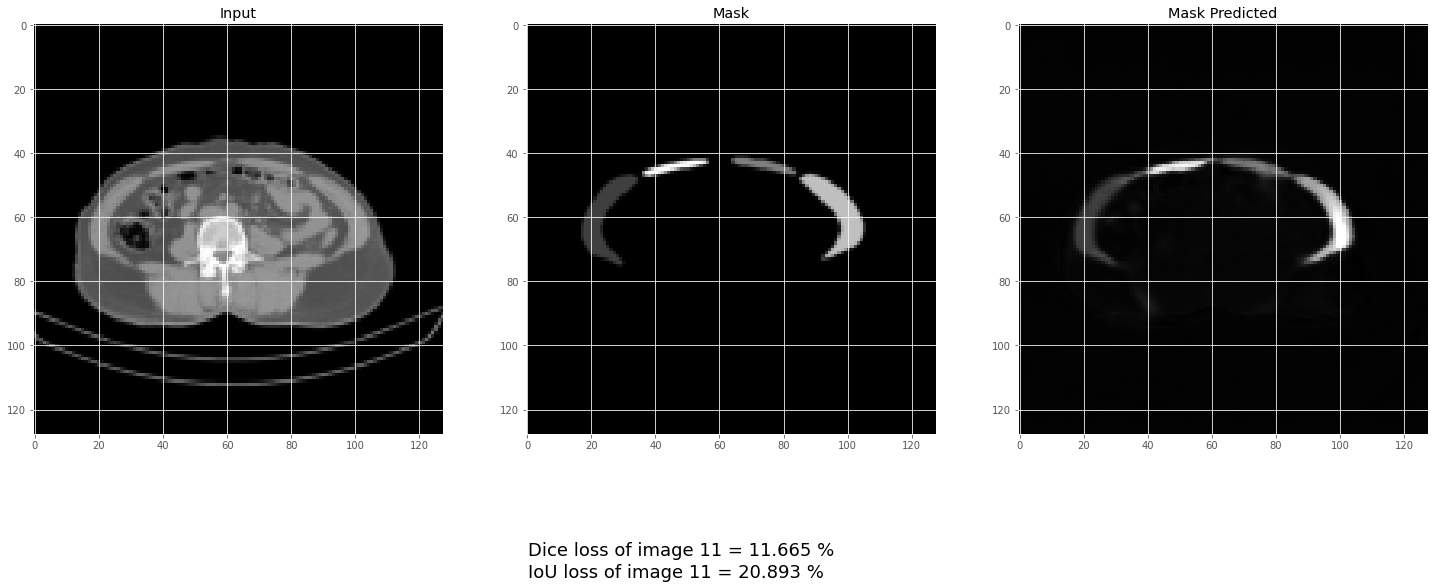

In [34]:
plot_sample(X_test, y_test, preds_test, test_text)

After Resizing

In [35]:
def upload_resize(root, folders, X, y, text):
    count_img = 0
    count_mask = 0
    
    print(text)
    
    for file in folders : 
        image_dir_path = root+ "/" +file
        mask_dir_path =  root+ "/" +file
        
        for img_path in tqdm(sorted(glob.glob(os.path.join(image_dir_path, "*_img.png")))):
            img = load_img(img_path, color_mode = "grayscale")
            img = img_to_array(img)
            img = resize(img, (512, 512, 1), mode = 'constant', preserve_range = True)
            img = img/255.0
            X[count_img]=img 
            count_img+=1
        print("Image upload count = ", count_img)
        
        
        for mask_path in tqdm(sorted(glob.glob(os.path.join(mask_dir_path, "*_mask.png")))):
            mask = load_img(mask_path, color_mode = "grayscale")
            mask = img_to_array(mask)
            mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
            mask = mask/255.0
            y[count_mask]=mask
            count_mask+=1
        print("Mask upload count = ", count_mask)
    return X,y

In [36]:
im_width_resize = 512
im_height_resize = 512

X_resize = np.zeros((int(train_total/2), im_height_resize, im_width_resize, 1), dtype=np.float32)
y_resize = np.zeros((int(train_total/2), im_height_resize, im_width_resize, 1), dtype=np.float32)

X_test_resize = np.zeros((int(test_total/2), im_height_resize, im_width_resize, 1), dtype=np.float32)
y_test_resize = np.zeros((int(test_total/2), im_height_resize, im_width_resize, 1), dtype=np.float32)

In [37]:
def avg_loss():
    d_loss_train = 0
    d_loss_valid = 0
    d_loss_test = 0

    temp = 0

    d_loss_train_list = []
    d_loss_valid_list = []
    d_loss_test_list = []
    
    for i in tqdm(range(0,len(X_train))):
        #temp = resize(preds_train[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_train = dice_loss(y_train[i],preds_train[i]).numpy()
        d_loss_train_list.append(d_loss_train)
        
    #d_loss_train_std = statistics.stdev(d_loss_train_list)
    #d_loss_train_avg = statistics.mean(d_loss_train_list)
    
    temp = 0
    
    
    for i in tqdm(range(0,len(X_valid))):
        #temp = resize(preds_val[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_valid = dice_loss(y_valid[i],preds_val[i]).numpy()
        d_loss_valid_list.append(d_loss_valid)
        
    temp = 0
    
    for i in tqdm(range(0,len(X_test))):
        #temp = resize(preds_test[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_test = dice_loss(y_test[i],preds_test[i]).numpy()
        d_loss_test_list.append(d_loss_test)
        
        

    #d_loss_valid_std = statistics.stdev(d_loss_valid_list)
    #d_loss_valid_avg = statistics.mean(d_loss_valid_list)
    return d_loss_train_list, d_loss_valid_list, d_loss_test_list
#d_loss_train_avg,d_loss_valid_avg,d_loss_train_std,d_loss_valid_std



In [38]:
a,b,c = avg_loss() #List of training and validation values
print(len(a),len(b), len(c))

100%|██████████████████████████████████████████| 26/26 [00:00<00:00, 994.07it/s]

180 46 26


In [39]:
case_1 = c[:5:]
case_2 = c[5:10:]
case_3 = c[10:15:]
case_4 = c[15:21:]
case_5 = c[21::]

In [40]:
print("Mean Dice loss of standard U-Net for training: ",statistics.mean(a), " Max : ", max(a), "Min :", min(a))
print("Mean Dice loss of standard U-Net for valid: ",statistics.mean(b), "Max : ", max(b), "Min : ", min(b))

Mean Dice loss of standard U-Net for training:  0.043319665  Max :  0.07342887 Min : 0.031191885
Mean Dice loss of standard U-Net for valid:  0.04762626 Max :  0.073862195 Min :  0.03298098


In [41]:
print("Mean Dice loss of standard U-Net for test-1: ",statistics.mean(case_1), "Max : ", max(case_1), "Min : ", min(case_1))
print("Mean Dice loss of standard U-Net for test-2: ",statistics.mean(case_2), "Max : ", max(case_2), "Min : ", min(case_2))
print("Mean Dice loss of standard U-Net for test-3: ",statistics.mean(case_3), "Max : ", max(case_3), "Min : ", min(case_3))
print("Mean Dice loss of standard U-Net for test-4: ",statistics.mean(case_4), "Max : ", max(case_4), "Min : ", min(case_4))
print("Mean Dice loss of standard U-Net for test-5: ",statistics.mean(case_5), "Max : ", max(case_5), "Min : ", min(case_5))

Mean Dice loss of standard U-Net for test-1:  0.19157377 Max :  0.208826 Min :  0.14695823
Mean Dice loss of standard U-Net for test-2:  0.13632092 Max :  0.16112155 Min :  0.11219716
Mean Dice loss of standard U-Net for test-3:  0.10358031 Max :  0.12676024 Min :  0.08450419
Mean Dice loss of standard U-Net for test-4:  0.1249578 Max :  0.16606832 Min :  0.095614314
Mean Dice loss of standard U-Net for test-5:  0.37474754 Max :  0.4255792 Min :  0.3107224


In [42]:
X_resize, y_resize = upload_resize(train_root, train_folders, X_resize, y_resize, train_text)

						Training 


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 42.10it/s]


Image upload count =  78


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 48.63it/s]


Mask upload count =  78


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 42.74it/s]


Image upload count =  106


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 48.42it/s]


Mask upload count =  106


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 43.41it/s]


Image upload count =  128


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 48.24it/s]


Mask upload count =  128


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 43.59it/s]


Image upload count =  159


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 48.36it/s]


Mask upload count =  159


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 44.29it/s]


Image upload count =  184


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 48.47it/s]


Mask upload count =  184


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 42.39it/s]


Image upload count =  205


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 48.30it/s]


Mask upload count =  205


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 43.65it/s]


Image upload count =  226


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 47.30it/s]

Mask upload count =  226


In [43]:
X_test_resize, y_test_resize = upload_resize(test_root, test_folders, X_test_resize, y_test_resize, test_text)

							Testing 


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 42.22it/s]


Image upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.73it/s]


Mask upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.33it/s]


Image upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.86it/s]


Mask upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 41.81it/s]


Image upload count =  15


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 47.52it/s]


Mask upload count =  15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 41.43it/s]


Image upload count =  21


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 45.36it/s]


Mask upload count =  21


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 41.42it/s]


Image upload count =  26


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 42.09it/s]

Mask upload count =  26


In [44]:
X_train_resize, X_valid_resize, y_train_resize, y_valid_resize = train_test_split(X_resize, y_resize, train_size = 0.8, random_state = 0)

						Training 


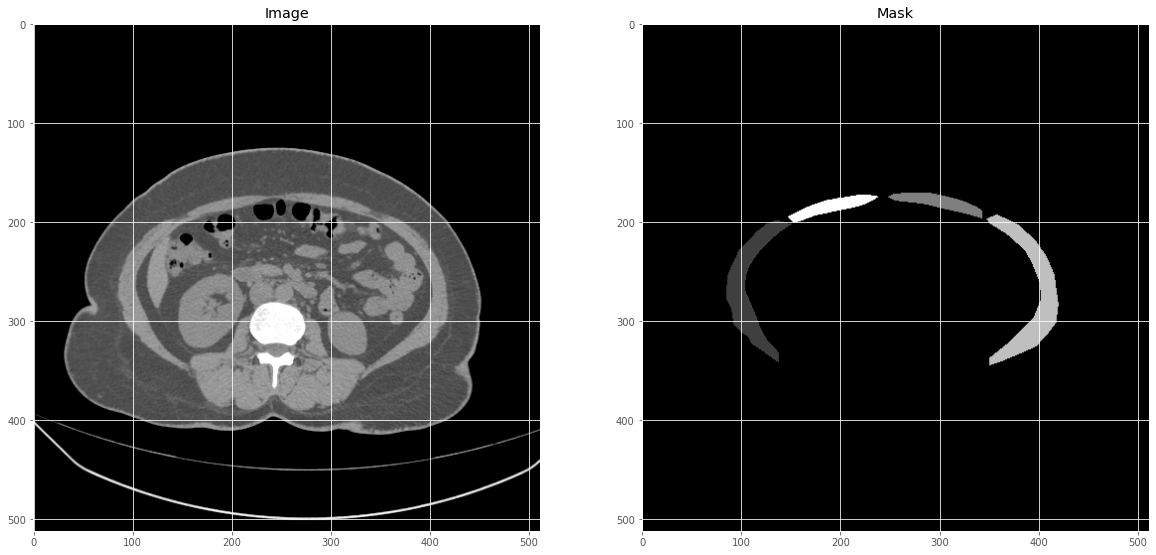

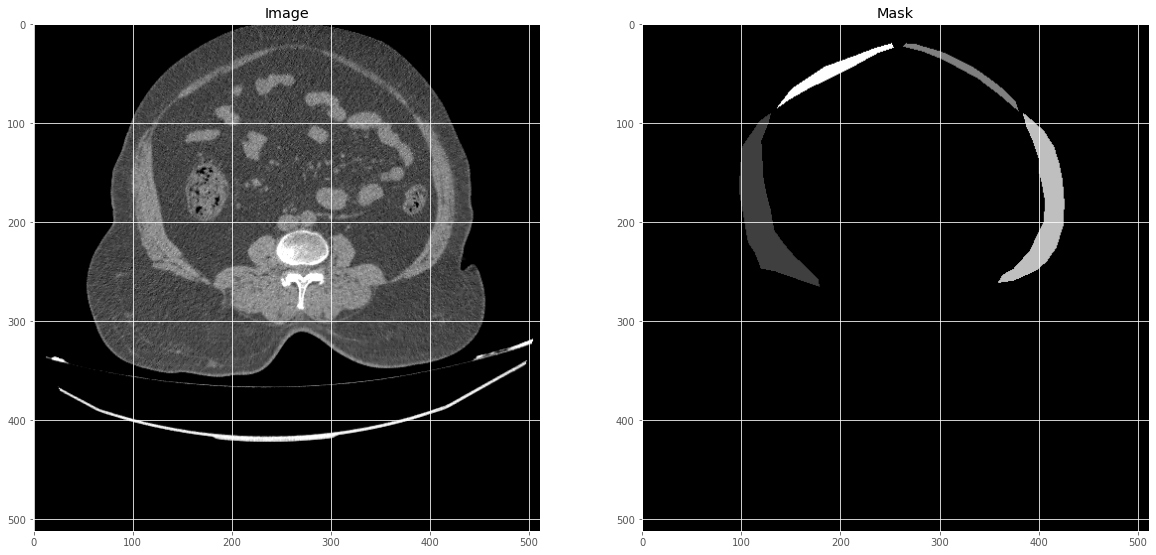

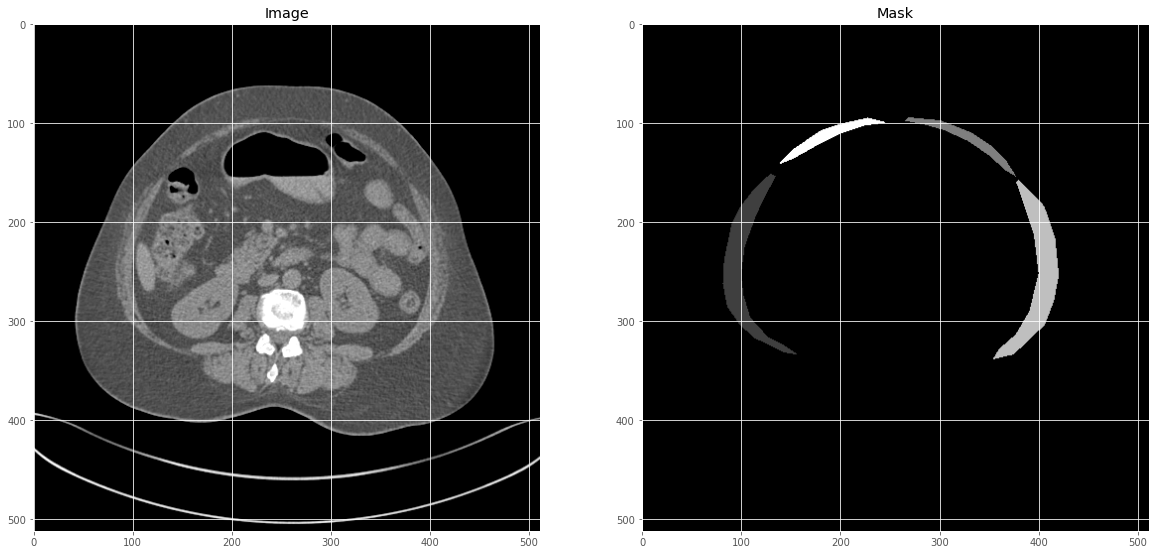

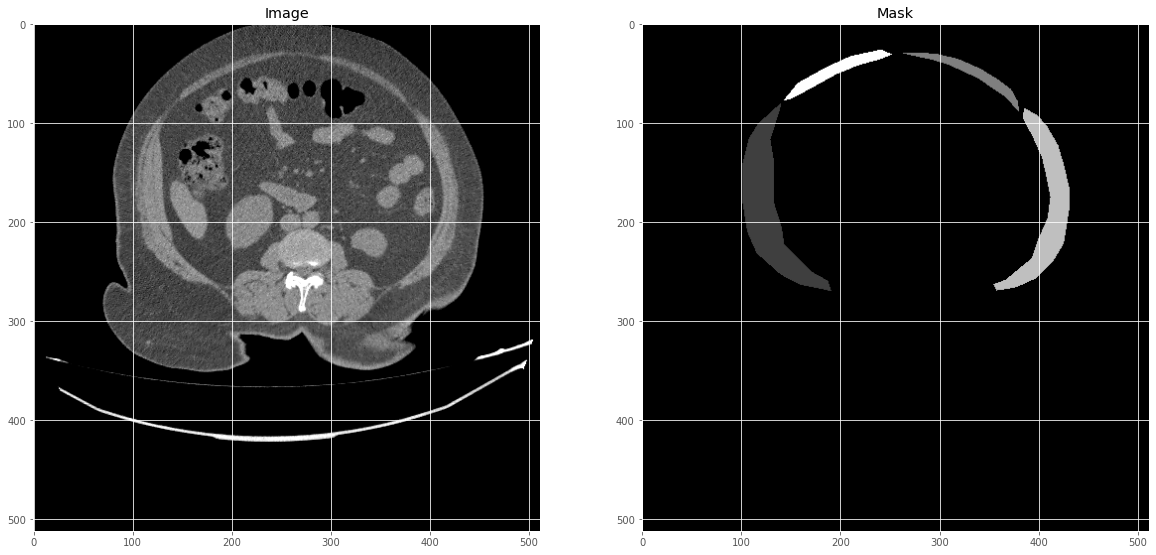

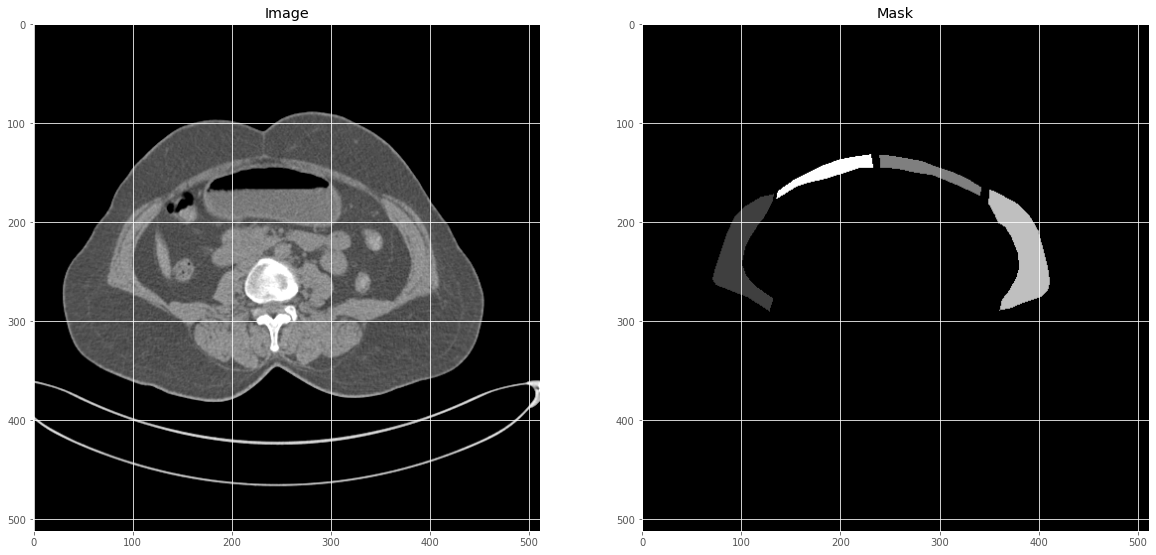

In [45]:
pre_visualize(X_train_resize, y_train_resize, train_text)

In [46]:
def avg_loss_resize():
    d_loss_train = 0
    d_loss_valid = 0
    d_loss_test = 0

    temp = 0

    d_loss_train_list = []
    d_loss_valid_list = []
    d_loss_test_list = []
    
    for i in tqdm(range(0,len(X_train))):
        temp = resize(preds_train[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_train = dice_loss(y_train_resize[i],temp).numpy()
        d_loss_train_list.append(d_loss_train)
        
    #d_loss_train_std = statistics.stdev(d_loss_train_list)
    #d_loss_train_avg = statistics.mean(d_loss_train_list)
    
    temp = 0
    
    
    for i in tqdm(range(0,len(X_valid))):
        temp = resize(preds_val[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_valid = dice_loss(y_valid_resize[i],temp).numpy()
        d_loss_valid_list.append(d_loss_valid)
        
    temp = 0
    
    for i in tqdm(range(0,len(X_test_resize))):
        temp = resize(preds_test[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_test = dice_loss(y_test_resize[i],temp).numpy()
        d_loss_test_list.append(d_loss_test)
        
        

    #d_loss_valid_std = statistics.stdev(d_loss_valid_list)
    #d_loss_valid_avg = statistics.mean(d_loss_valid_list)
    return d_loss_train_list, d_loss_valid_list, d_loss_test_list
#d_loss_train_avg,d_loss_valid_avg,d_loss_train_std,d_loss_valid_std

In [47]:
a,b, c = avg_loss_resize() #List of training and validation values
print(len(a),len(b), len(c))

100%|███████████████████████████████████████████| 26/26 [00:00<00:00, 57.45it/s]

180 46 26


In [48]:
case_1 = c[:5:]
case_2 = c[5:10:]
case_3 = c[10:15:]
case_4 = c[15:21:]
case_5 = c[21::]

In [49]:
print("Mean Dice loss of standard U-Net for training: ",statistics.mean(a), " Max : ", max(a), "Min :", min(a))
print("Mean Dice loss of standard U-Net for valid: ",statistics.mean(b), "Max : ", max(b), "Min : ", min(b))

Mean Dice loss of standard U-Net for training:  0.093520105  Max :  0.1328361 Min : 0.06754041
Mean Dice loss of standard U-Net for valid:  0.09827304 Max :  0.13185233 Min :  0.07061577


In [50]:
print("Mean Dice loss of standard U-Net for test-1: ",statistics.mean(case_1), "Max : ", max(case_1), "Min : ", min(case_1))
print("Mean Dice loss of standard U-Net for test-2: ",statistics.mean(case_2), "Max : ", max(case_2), "Min : ", min(case_2))
print("Mean Dice loss of standard U-Net for test-3: ",statistics.mean(case_3), "Max : ", max(case_3), "Min : ", min(case_3))
print("Mean Dice loss of standard U-Net for test-4: ",statistics.mean(case_4), "Max : ", max(case_4), "Min : ", min(case_4))
print("Mean Dice loss of standard U-Net for test-5: ",statistics.mean(case_5), "Max : ", max(case_5), "Min : ", min(case_5))

Mean Dice loss of standard U-Net for test-1:  0.25206402 Max :  0.26324308 Min :  0.21881324
Mean Dice loss of standard U-Net for test-2:  0.17455909 Max :  0.19640577 Min :  0.15231723
Mean Dice loss of standard U-Net for test-3:  0.14685819 Max :  0.16558862 Min :  0.1271801
Mean Dice loss of standard U-Net for test-4:  0.16831596 Max :  0.20681256 Min :  0.13911706
Mean Dice loss of standard U-Net for test-5:  0.4157768 Max :  0.46201843 Min :  0.35527712
